# Análise dos testes

### Imports

In [9]:
from os import makedirs
from os.path import join
from json import load, dump

from scripts.test import Test
from scripts.data import SimpleLesionData, SimpleDatasetAnalysis

import scripts.definitions as defs
import scripts.analysis as analysis

### Configuração

In [10]:
TEST_NAME = 'LLaDerm-0.21-11B_test_2025-04-16T15_10_27.906580.json'

### Carregamento dos testes e dados

In [11]:
with open(join(defs.RESULTS_PATH, 'tests', TEST_NAME), 'r', encoding='utf-8') as file:
    test = Test(**load(file))

with open(join(defs.DATA_PATH, 'stt_data', 'test_dataset.json'), 'r', encoding='utf-8') as file:
    test_dataset = [SimpleLesionData(**data) for data in load(file)]

with open(join(defs.DATA_PATH, 'stt_data', 'training_dataset.json'), 'r', encoding='utf-8') as file:
    training_dataset = [SimpleLesionData(**data) for data in load(file)]

with open(join(defs.DATA_PATH, 'test_dataset_analysis.json'), 'r', encoding='utf-8') as file:
    test_dataset_analysis = SimpleDatasetAnalysis(**load(file))

with open(join(defs.DATA_PATH, 'training_dataset_analysis.json'), 'r', encoding='utf-8') as file:
    training_dataset_analysis = SimpleDatasetAnalysis(**load(file))

### Processamento dos testes

In [12]:
sanitized_results_on_test = analysis.structure_answers(test.model.prompt_type, test.results_on_test_data)
sanitized_results_on_training = analysis.structure_answers(test.model.prompt_type, test.results_on_training_data)

### Salvamento dos testes processados

In [13]:
valid_results_on_test = list(filter(lambda x: x.answer.valid, sanitized_results_on_test))
invalid_results_on_test = list(filter(lambda x: not x.answer.valid, sanitized_results_on_test))

print(
    f'Resultados válidos para testes sobre dados de teste: {len(sanitized_results_on_test) - len(invalid_results_on_test)}')
print(f'Resultados inválidos para testes sobre dados de teste: {len(invalid_results_on_test)}')

valid_results_on_training = list(filter(lambda x: x.answer.valid, sanitized_results_on_training))
invalid_results_on_training = list(filter(lambda x: not x.answer.valid, sanitized_results_on_training))

print(
    f'Resultados válidos para testes sobre dados de treinamento: {len(sanitized_results_on_training) - len(invalid_results_on_training)}')
print(f'Resultados inválidos para testes sobre dados de treinamento: {len(invalid_results_on_training)}')

test_analysis = analysis.TestAnalysis(
    test_name=TEST_NAME,
    valid_results_on_test_data=valid_results_on_test,
    valid_results_on_training_data=valid_results_on_training,
    invalid_results_on_test_data=invalid_results_on_test,
    invalid_results_on_training_data=invalid_results_on_training
)

makedirs(join(defs.RESULTS_PATH, 'tests', 'analysis'), exist_ok=True)

with open(join(defs.RESULTS_PATH, 'tests', 'analysis', TEST_NAME.replace('.json', '_analysis.json')), 'w', encoding='utf-8') as file:
    dump(test_analysis.model_dump(), file, indent=4, ensure_ascii=False)

Resultados válidos para testes sobre dados de teste: 1166
Resultados inválidos para testes sobre dados de teste: 1
Resultados válidos para testes sobre dados de treinamento: 4735
Resultados inválidos para testes sobre dados de treinamento: 1


### Associação de pares com as respostas corretas

In [14]:
result_pairs_on_test = analysis.associate_results_with_data(test_dataset,
                                                            test.model.prompt_type,
                                                            sanitized_results_on_test)

result_pairs_on_training = analysis.associate_results_with_data(training_dataset,
                                                                test.model.prompt_type,
                                                                sanitized_results_on_training)

### Análise dos testes sobre os dados de teste

Acurácia - Lesões de pele - Teste: 44.5%
Precisão - Lesões de pele - Teste: 43.1%
Recall - Lesões de pele - Teste: 44.5%
F1 - Lesões de pele - Teste: 42.5%


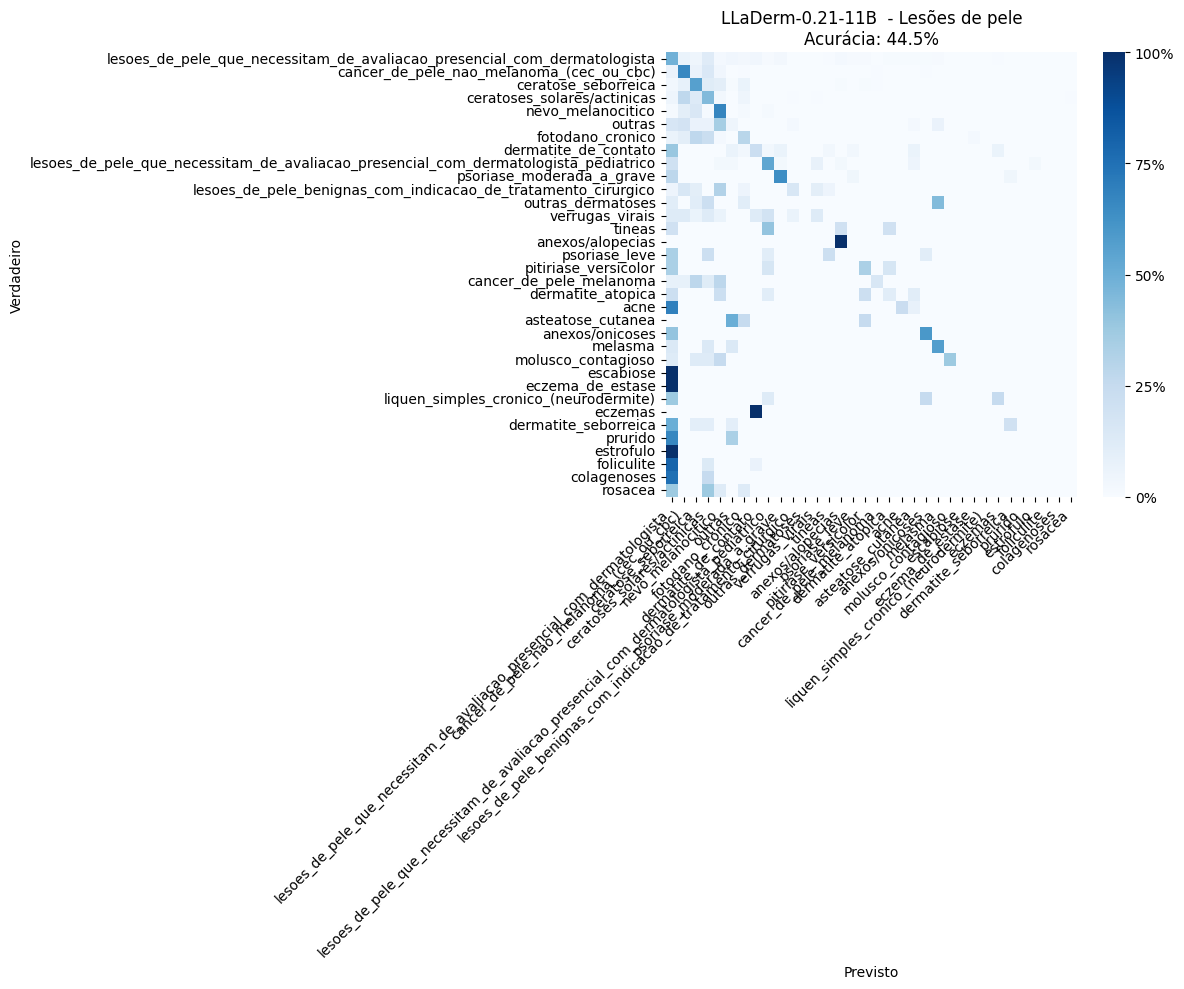

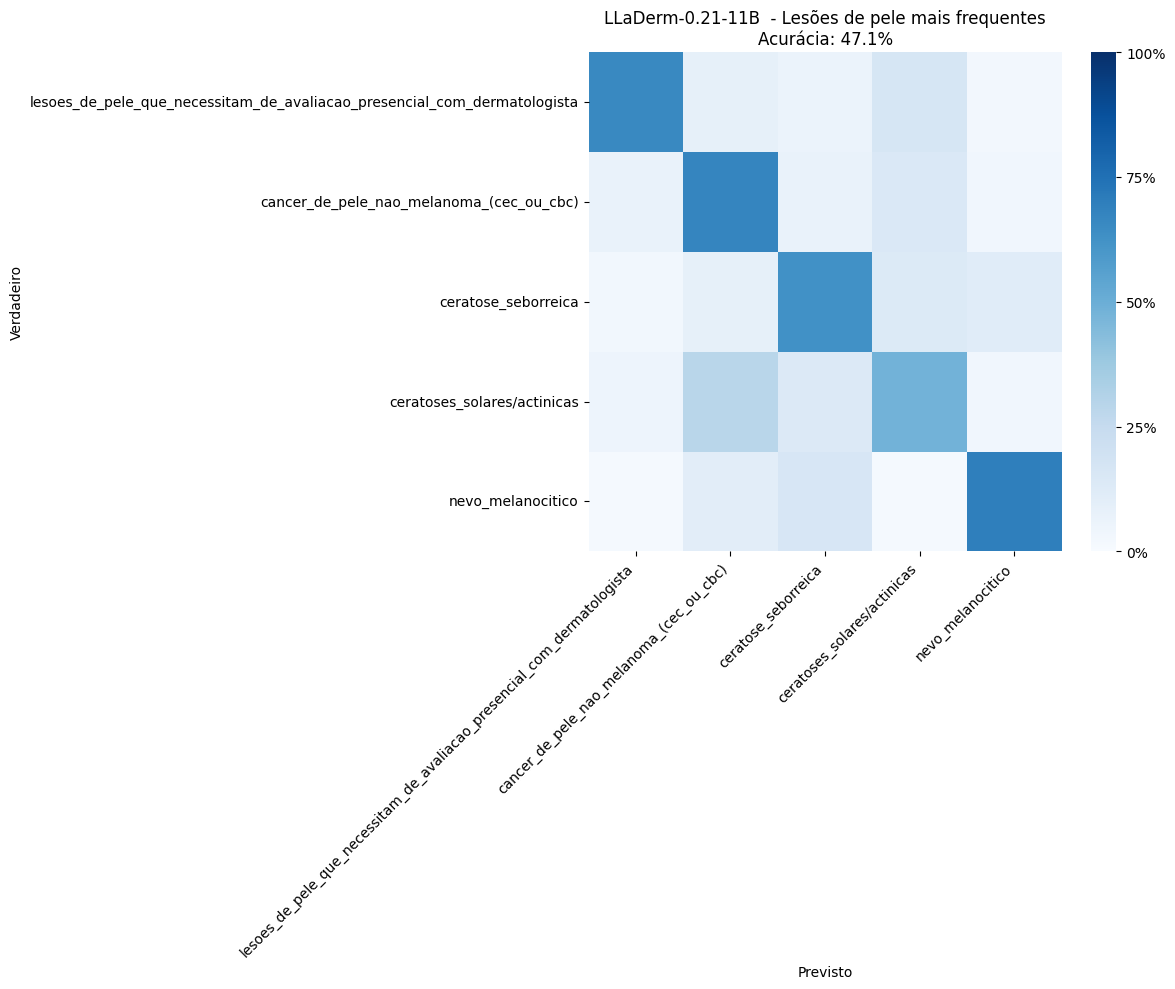

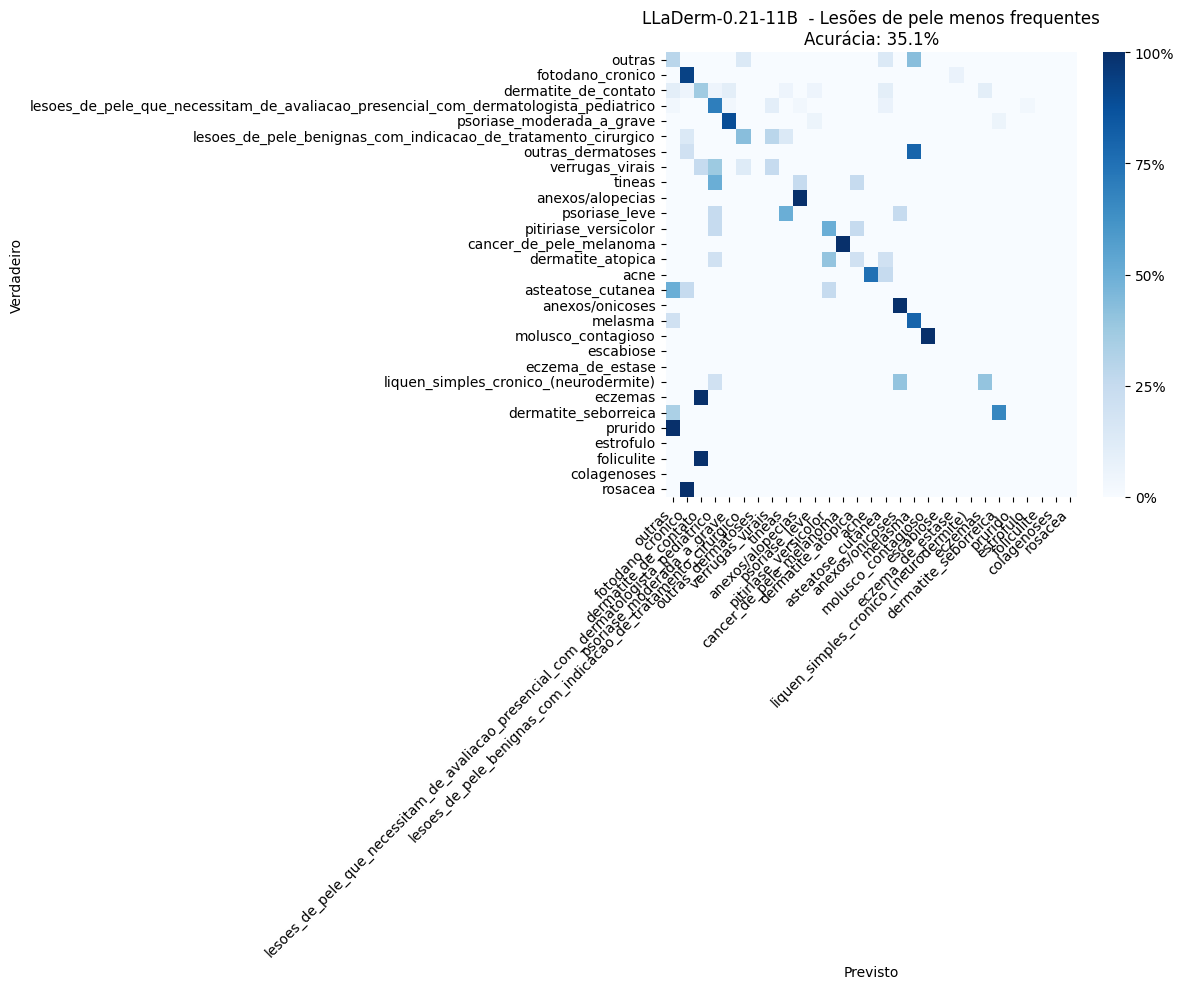

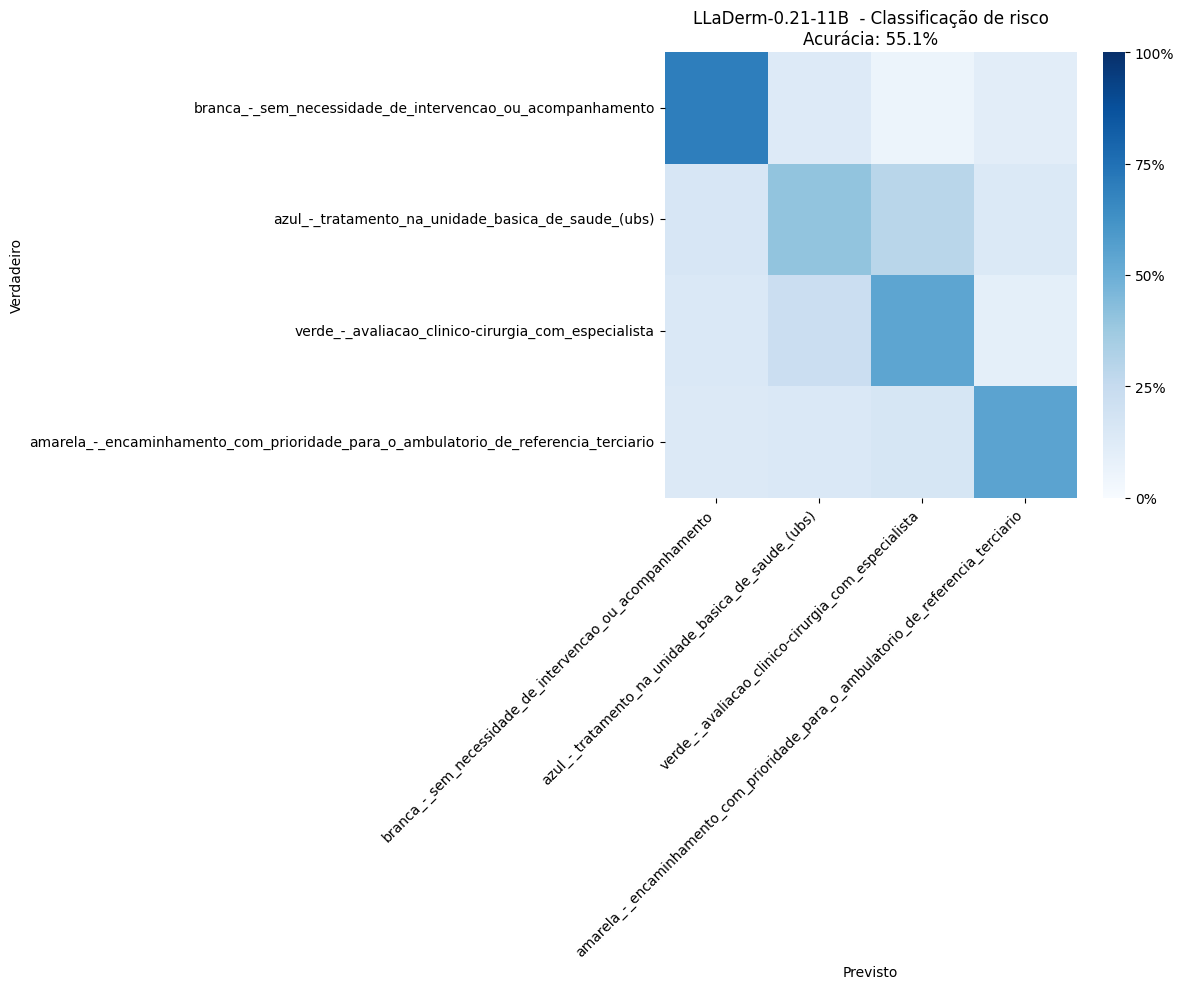

In [15]:
# TODO: Melhorar as métricas
model_name = test.tested_model
quantized = '(Quantizado)' if test.model.quantized else ''

if len(result_pairs_on_test) > 0:
    skin_lesion_pairs = analysis.get_label_pairs(result_pairs_on_test, 'skin_lesion')

    split = analysis.split_pairs(skin_lesion_pairs, training_dataset_analysis.skin_lesion_distribution.classes, 5)

    print(f'Acurácia - Lesões de pele - Teste: {analysis.calculate_accuracy(skin_lesion_pairs) * 100.0:.1f}%')
    print(f'Precisão - Lesões de pele - Teste: {analysis.calculate_precision(skin_lesion_pairs) * 100.0:.1f}%')
    print(f'Recall - Lesões de pele - Teste: {analysis.calculate_recall(skin_lesion_pairs) * 100.0:.1f}%')
    print(f'F1 - Lesões de pele - Teste: {analysis.calculate_f1(skin_lesion_pairs) * 100.0:.1f}%')

    most_frequent_skin_lesion_pairs = split[0]
    least_frequent_skin_lesion_pairs = split[1]
    most_frequent_classes = split[2]
    least_frequent_classes = split[3]
    skin_lesion_classes = most_frequent_classes + least_frequent_classes

    analysis.create_confusion_matrix(skin_lesion_pairs,  # type: ignore
                                     skin_lesion_classes,
                                     f'{model_name} {quantized} - Lesões de pele',
                                     join(defs.RESULTS_PATH, 'plots', f'skin_lesions_{TEST_NAME[:-4]}'))

    analysis.create_confusion_matrix(most_frequent_skin_lesion_pairs,  # type: ignore
                                     most_frequent_classes,
                                     f'{model_name} {quantized} - Lesões de pele mais frequentes',
                                     join(defs.RESULTS_PATH, 'plots', f'skin_lesions_{TEST_NAME[:-4]}'))

    analysis.create_confusion_matrix(least_frequent_skin_lesion_pairs,  # type: ignore
                                     least_frequent_classes,
                                     f'{model_name} {quantized} - Lesões de pele menos frequentes',
                                     join(defs.RESULTS_PATH, 'plots', f'skin_lesions_{TEST_NAME[:-4]}'))

    if test.model.prompt_type == defs.PromptType.REPORT:
        risk_pairs = analysis.get_label_pairs(result_pairs_on_test, 'risk')

        risk_labels = [analysis.sanitize_domain_class(key) for key in
                       training_dataset_analysis.risk_distribution.classes]

        risk_accuracy = analysis.create_confusion_matrix(risk_pairs,  # type: ignore
                                                         risk_labels,
                                                         f'{model_name} {quantized} - Classificação de risco',
                                                         join(defs.RESULTS_PATH, 'plots', f'risk_{TEST_NAME[:-4]}'))

### Análise dos testes sobre os dados de treinamento

Acurácia - Lesões de pele - Teste: 59.0%
Precisão - Lesões de pele - Teste: 58.7%
Recall - Lesões de pele - Teste: 59.0%
F1 - Lesões de pele - Teste: 57.6%


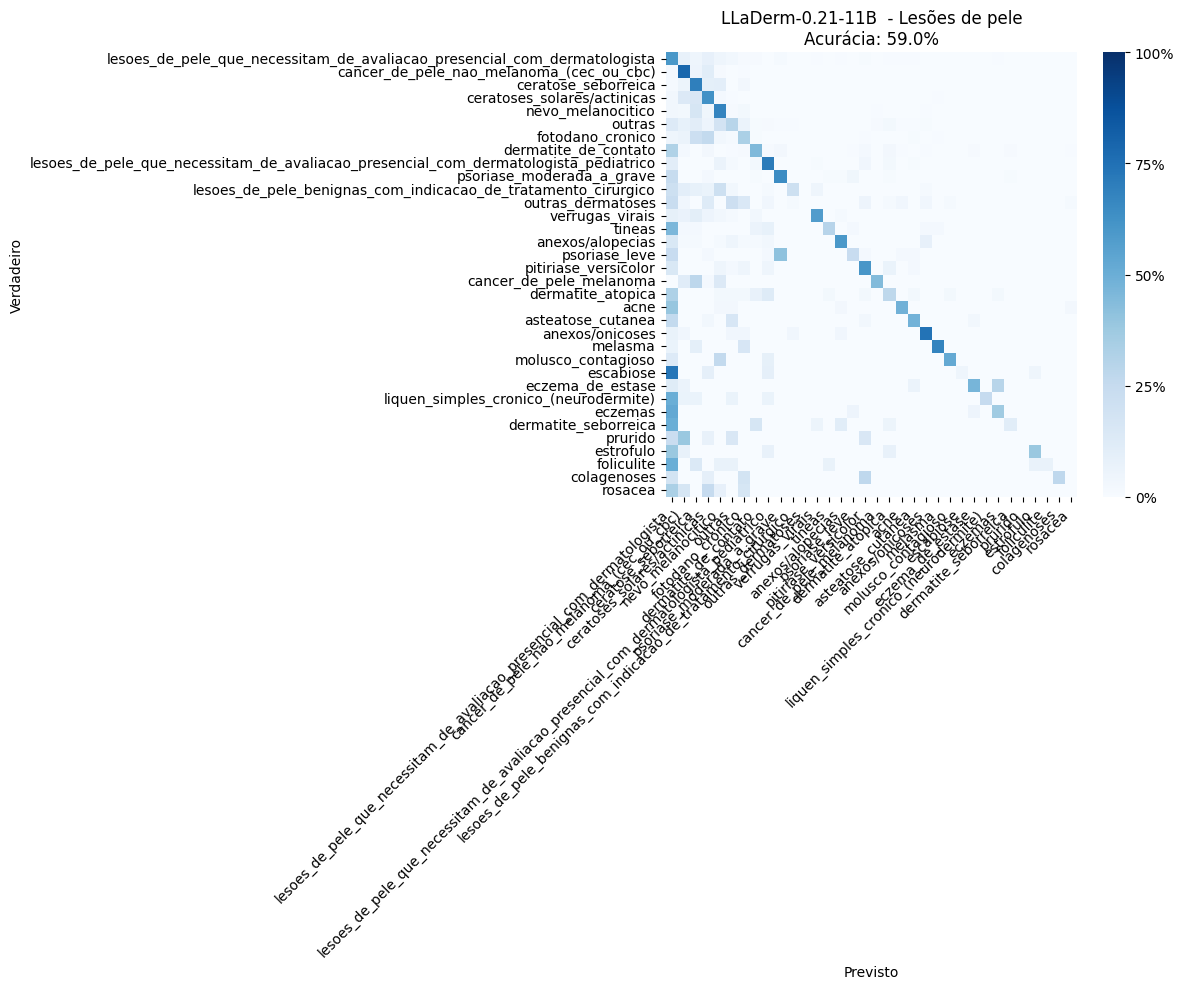

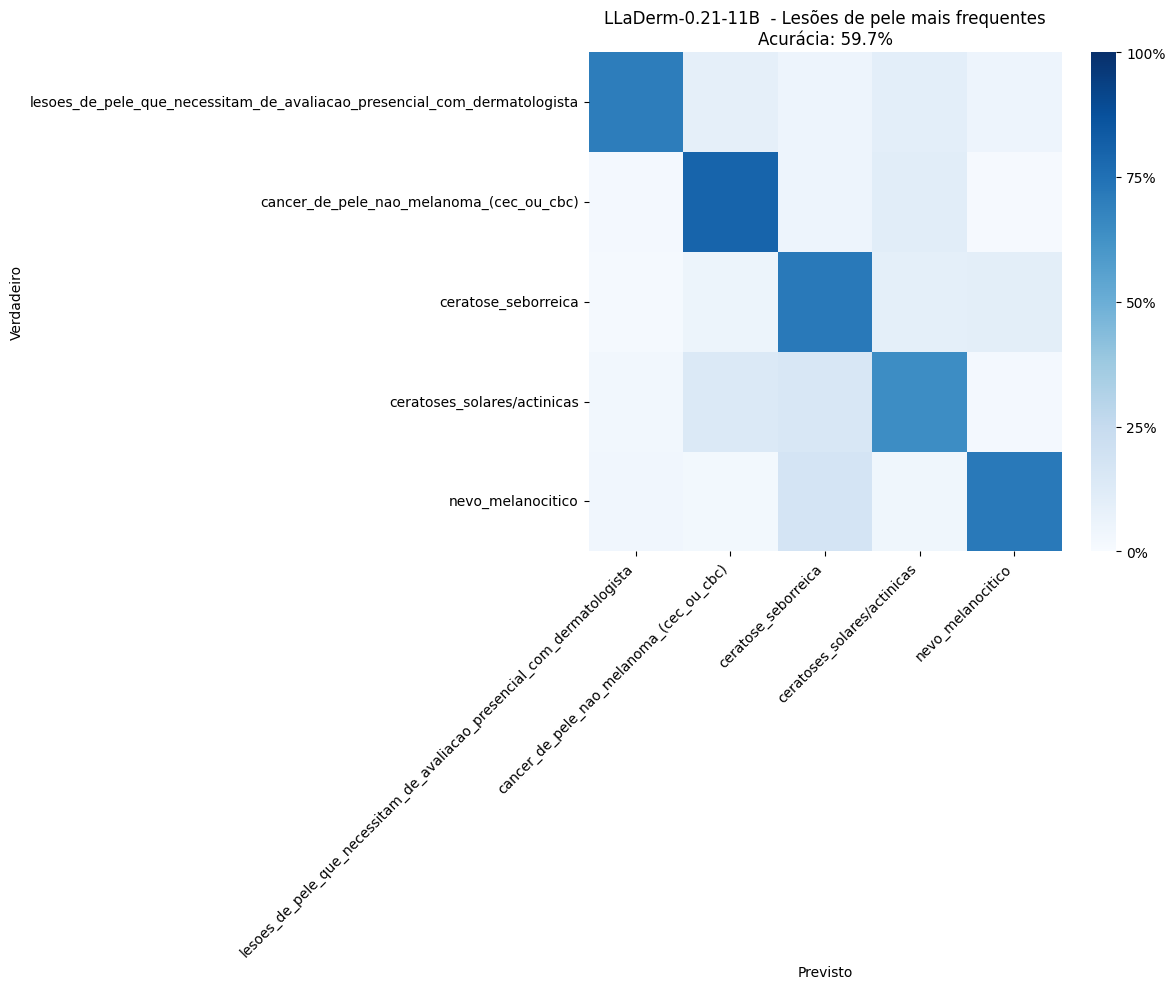

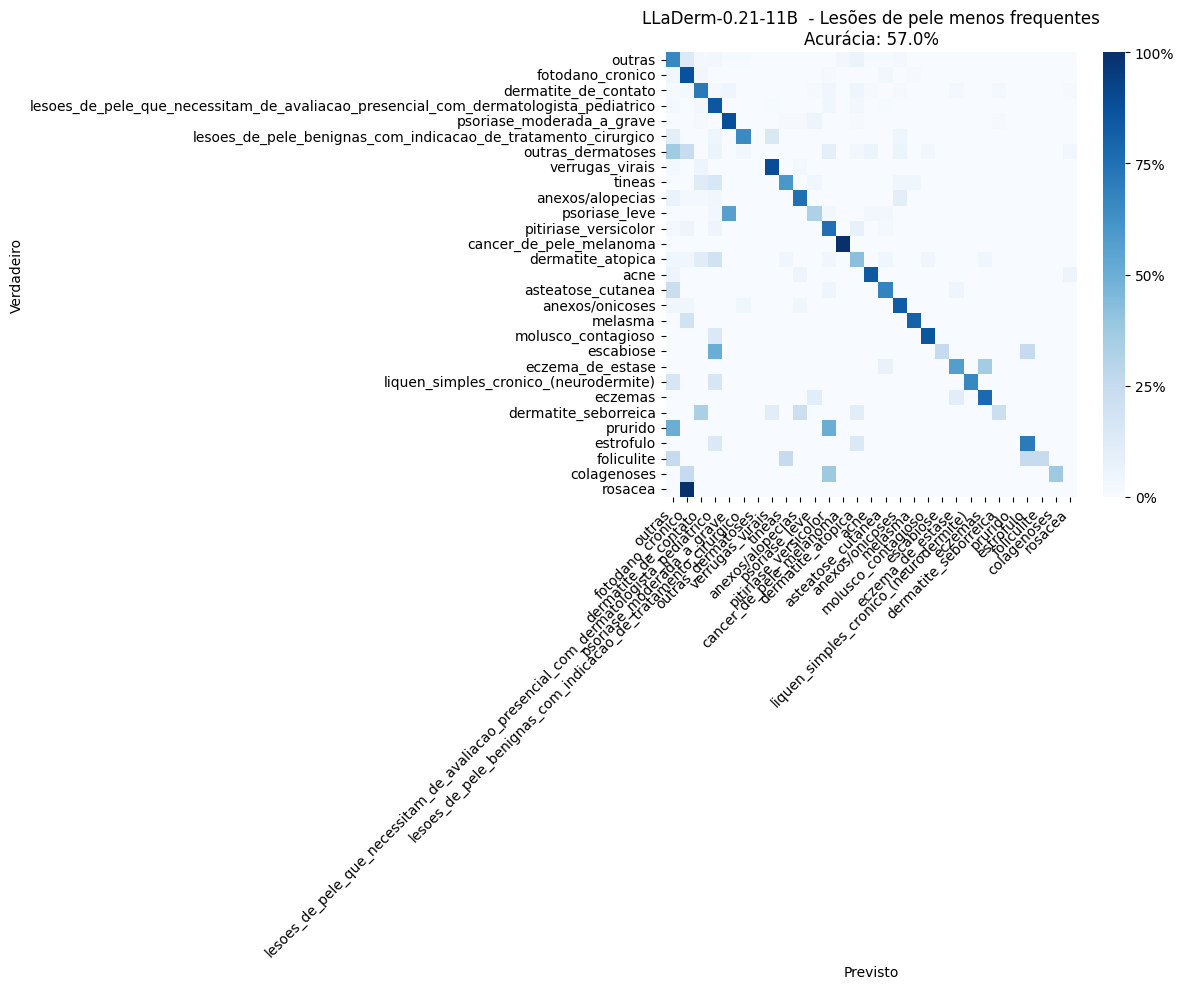

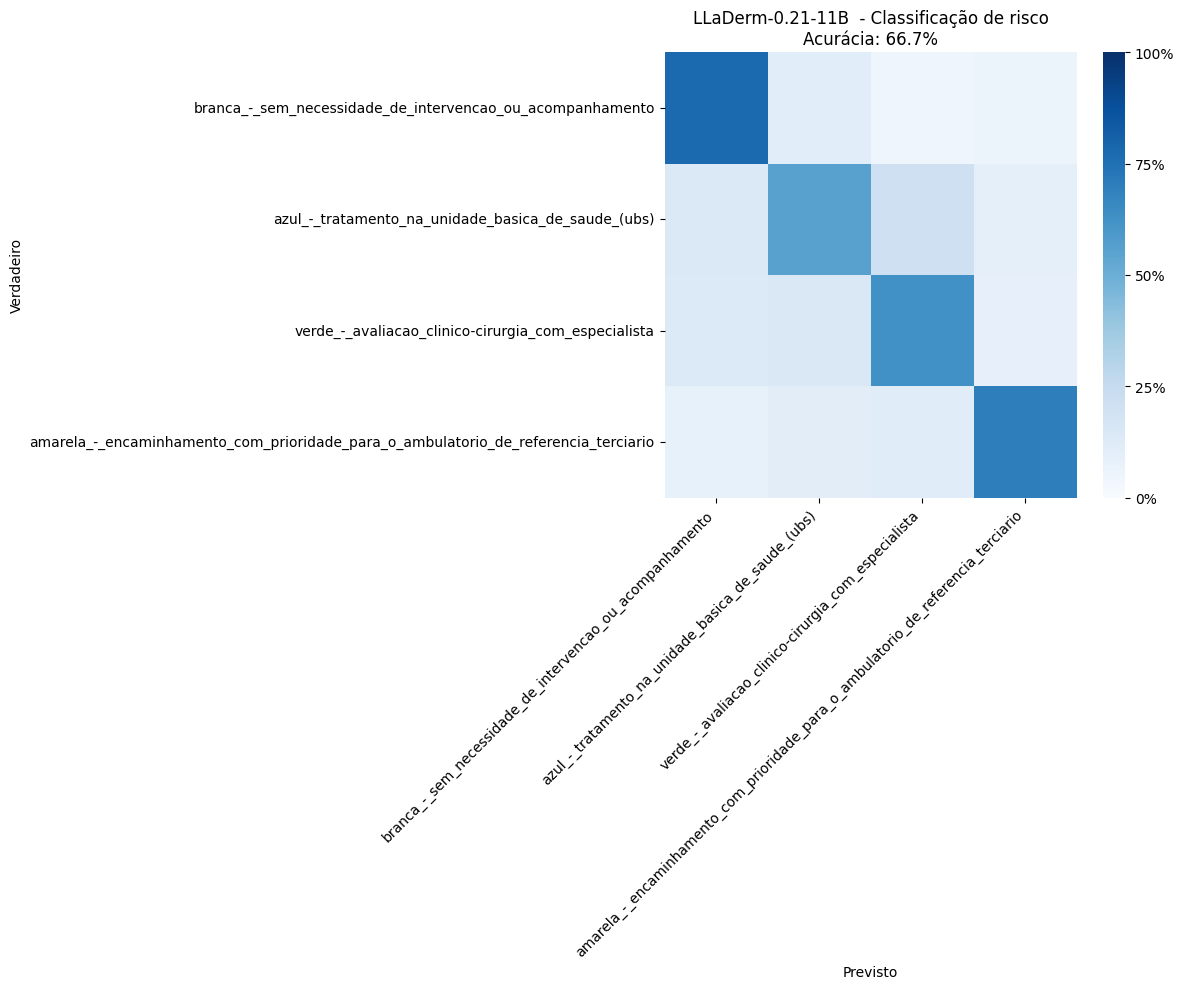

In [16]:
if len(result_pairs_on_training) > 0:
    skin_lesion_pairs = analysis.get_label_pairs(result_pairs_on_training, 'skin_lesion')

    split = analysis.split_pairs(skin_lesion_pairs, training_dataset_analysis.skin_lesion_distribution.classes, 5)

    print(f'Acurácia - Lesões de pele - Teste: {analysis.calculate_accuracy(skin_lesion_pairs) * 100.0:.1f}%')
    print(f'Precisão - Lesões de pele - Teste: {analysis.calculate_precision(skin_lesion_pairs) * 100.0:.1f}%')
    print(f'Recall - Lesões de pele - Teste: {analysis.calculate_recall(skin_lesion_pairs) * 100.0:.1f}%')
    print(f'F1 - Lesões de pele - Teste: {analysis.calculate_f1(skin_lesion_pairs) * 100.0:.1f}%')

    most_frequent_skin_lesion_pairs = split[0]
    least_frequent_skin_lesion_pairs = split[1]
    most_frequent_classes = split[2]
    least_frequent_classes = split[3]
    skin_lesion_classes = most_frequent_classes + least_frequent_classes

    analysis.create_confusion_matrix(skin_lesion_pairs,  # type: ignore
                                     skin_lesion_classes,
                                     f'{model_name} {quantized} - Lesões de pele',
                                     join(defs.RESULTS_PATH, 'plots', f'skin_lesions_{TEST_NAME[:-4]}'))

    analysis.create_confusion_matrix(most_frequent_skin_lesion_pairs,  # type: ignore
                                     most_frequent_classes,
                                     f'{model_name} {quantized} - Lesões de pele mais frequentes',
                                     join(defs.RESULTS_PATH, 'plots', f'skin_lesions_{TEST_NAME[:-4]}'))

    analysis.create_confusion_matrix(least_frequent_skin_lesion_pairs,  # type: ignore
                                     least_frequent_classes,
                                     f'{model_name} {quantized} - Lesões de pele menos frequentes',
                                     join(defs.RESULTS_PATH, 'plots', f'skin_lesions_{TEST_NAME[:-4]}'))

    if test.model.prompt_type == defs.PromptType.REPORT:
        risk_pairs = analysis.get_label_pairs(result_pairs_on_training, 'risk')

        risk_labels = [analysis.sanitize_domain_class(key) for key in
                       training_dataset_analysis.risk_distribution.classes]

        risk_accuracy = analysis.create_confusion_matrix(risk_pairs,  # type: ignore
                                                         risk_labels,
                                                         f'{model_name} {quantized} - Classificação de risco',
                                                         join(defs.RESULTS_PATH, 'plots', f'risk_{TEST_NAME[:-4]}'))